In [1]:
import os
from fractions import Fraction
import pandas as pd
import seaborn as sns

In [2]:
data = '../Data/Beethoven_sonata_progression/'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time annotation1_chord annotation2_chord  sps  vl tbt  binary
01-1 0  0.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     1  0.25      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     2  0.50      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     3  0.75      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     4  1.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False

**Percentage of diverging labels** (binary=True)

In [3]:
D.binary.value_counts(normalize=True)

False    0.666784
True     0.333216
Name: binary, dtype: float64

### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [4]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.558847
True     0.441153
Name: binary, dtype: float64


In [5]:
df = D[D.binary] # select only diverging

**Overview Spectral Pitch distances**

count    3321.000000
mean        0.278306
std         0.262536
min         0.000000
25%         0.068873
50%         0.163216
75%         0.454415
max         0.960042
Name: sps, dtype: float64


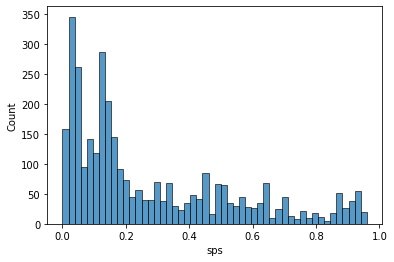

In [6]:
print(df.sps.describe())
sns.histplot(data=df, x='sps', bins=50);

**Overview Voice Leading distances**

count    3321.000000
mean        9.128877
std         5.975574
min         0.000000
25%         3.000000
50%         9.000000
75%        14.000000
max        24.000000
Name: vl, dtype: float64


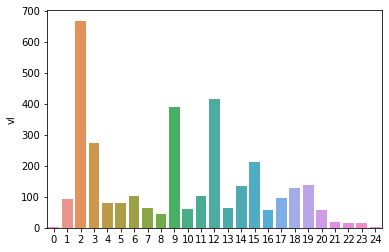

In [7]:
print(df.vl.describe())
vl = df.vl.value_counts()
sns.barplot(x=vl.index, y=vl);

**Overview tone-by-tone distances**

count    3321.000000
mean        0.498726
std         0.283832
min         0.125000
25%         0.285714
50%         0.428571
75%         0.750000
max         1.000000
Name: tbt, dtype: float64


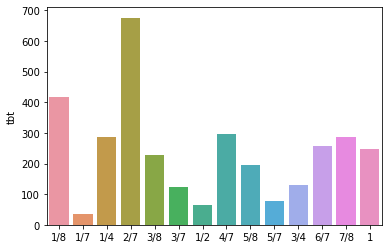

In [8]:
print(df.tbt.astype(float).describe())
tbt = df.tbt.value_counts()
sns.barplot(x=tbt.index, y=tbt);

## Expanding the data to inspect different categories of chord divergence

In [9]:
from ms3 import transform, name2fifths, fifths2pc
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
df = D[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv')], axis=1)
df.head()

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
01-1 30   5.25  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2  0.049170   2  3/8   
     43   7.25       C_MAJOR_inv0   C_MAJ_MIN7_inv0  0.006025   2  1/8   
     56  10.25   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1  0.075546  15  1/4   
     87  16.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   
     95  18.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   

         binary root1       type1 inv1  tpc1  pc1 root2     type2 inv2  tpc2  \
01-1 30    True     E  DIMINISHED    1     4    4     C  MAJ_MIN7    2     0   
     43    True     C       MAJOR    0     0    0     C  MAJ_MIN7    0     0   
     56    True    Db    MAJ_MAJ7    3    -5    1    Db  MAJ_MAJ7    1    -5   
     87    True    Ab       MAJOR    1    -4    8    Eb     MAJOR    0    -3   
     95    True    Ab       MAJOR    1    -4    8    Eb     MAJOR    0    -3   

         pc2  tpc_iv  pc_iv  
01-1 30    0       4      4  
     43    0       0      0  
     56    1       0      0  
     87    3       1      5  
     95    3       1      5

In [10]:
same_root = df.tpc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2

### Inspecting chords diverging only by inversion
**Proportion of diverging chords that have the same root and type but different inversion (True)**

In [11]:
diverging_inv = same_root & same_type
diverging_inv.value_counts(normalize=True)

False    0.715748
True     0.284252
dtype: float64

In [12]:
inv_groups = df.loc[diverging_inv, ['inv1', 'inv2']]\
                 .apply(lambda row: tuple(sorted(row)), axis=1)\
                 .rename('inversions')
different_inversions = pd.concat([df[diverging_inv], inv_groups], axis=1)
different_inversions.groupby(['tbt', 'inversions']).size()

tbt  inversions
1/4  (0, 1)         50
     (0, 2)         42
     (0, 3)         42
     (1, 2)         42
     (1, 3)         33
     (2, 3)         59
2/7  (0, 1)        441
     (0, 2)        158
     (1, 2)         77
dtype: int64

**Grouping `tbt` values by combinations of inversions shows that all tetrads have the distance `1/4` and all triads the distance `2/7`** Note that the chords in question all share the same root.

In [13]:
different_inversions.groupby(['vl', 'type1', 'inversions']).size()

vl  type1       inversions
6   MAJ_MIN7    (0, 3)         34
9   DIM7        (0, 1)          3
                (0, 3)          8
                (1, 2)          6
                (2, 3)         10
    DIMINISHED  (0, 1)         21
                (1, 2)          2
    HALF_DIM7   (1, 2)          2
    MAJOR       (1, 2)         49
    MAJ_MIN7    (1, 2)         34
                (2, 3)         49
    MINOR       (0, 1)        145
    MIN_MIN7    (0, 1)          3
12  MAJOR       (0, 1)        275
    MAJ_MIN7    (0, 1)         44
    MINOR       (1, 2)         26
15  MAJOR       (0, 2)         82
    MAJ_MAJ7    (1, 3)          1
    MAJ_MIN7    (0, 2)         39
    MINOR       (0, 2)         71
18  DIM7        (0, 2)          2
                (1, 3)         16
    DIMINISHED  (0, 2)          5
    HALF_DIM7   (0, 2)          1
    MAJ_MIN7    (1, 3)         16
dtype: int64

**`18` is among the highest values that the voice leading distance yiels, so it is rather surprising that chords with the same root and type shall get this value**

In [14]:
different_inversions.groupby(['type1', 'inversions', 'sps']).size().head(60)

type1       inversions  sps     
DIM7        (0, 1)      0.091002     1
                        0.130723     2
            (0, 2)      0.076837     1
                        0.118461     1
            (0, 3)      0.057999     1
                        0.118810     6
                        0.124679     1
            (1, 2)      0.019882     1
                        0.029056     1
                        0.091002     1
                        0.114036     3
            (1, 3)      0.076837     1
                        0.147762    12
                        0.162639     1
                        0.170808     2
            (2, 3)      0.057999     1
                        0.111540     6
                        0.130723     1
                        0.140453     2
DIMINISHED  (0, 1)      0.024659     6
                        0.026499     2
                        0.036015     1
                        0.085481     2
                        0.130883     2
                        0.13350

**Surprising to see such different distances for transpositionally identical chord combinations**
As an example, let's inspect all cases where both datasets have a diminished 7th chord on the same root, one in first, one in second inversion:

In [15]:
different_inversions[(different_inversions.type1 == 'DIM7') & (different_inversions.inversions == ('1', '2'))]

time annotation1_chord annotation2_chord       sps  vl  tbt  \
03-1 2103  227.00000       B_DIM7_inv2       B_DIM7_inv1  0.114036   9  1/4   
     2115  228.00000      Db_DIM7_inv2      Db_DIM7_inv1  0.091002   9  1/4   
     2127  229.00000       B_DIM7_inv2       B_DIM7_inv1  0.114036   9  1/4   
32-1 994    85.53125      Gb_DIM7_inv2      Gb_DIM7_inv1  0.019882   9  1/4   
     1034   88.03125       E_DIM7_inv1       E_DIM7_inv2  0.029056   9  1/4   
     1603  129.78125       B_DIM7_inv2       B_DIM7_inv1  0.114036   9  1/4   

           binary root1 type1 inv1  tpc1  pc1 root2 type2 inv2  tpc2  pc2  \
03-1 2103    True     B  DIM7    2     5   11     B  DIM7    1     5   11   
     2115    True    Db  DIM7    2    -5    1    Db  DIM7    1    -5    1   
     2127    True     B  DIM7    2     5   11     B  DIM7    1     5   11   
32-1 994     True    Gb  DIM7    2    -6    6    Gb  DIM7    1    -6    6   
     1034    True     E  DIM7    1     4    4     E  DIM7    2     4    4   
     1603    True     B  DIM7    2     5   11     B  DIM7    1     5   11   

           tpc_iv  pc_iv inversions  
03-1 2103       0      0     (1, 2)  
     2115       0      0     (1, 2)  
     2127       0      0     (1, 2)  
32-1 994        0      0     (1, 2)  
     1034       0      0     (1, 2)  
     1603       0      0     (1, 2)